# Tutorial: Fermi GBM TTE Data

Adapted from "TTE Data" in the Fermi GBM Data Tools documentation and "Fermi GBM TTE Data" in the Fermi Gamma-ray Data Tools documentation.

TTE (Time-Tagged Event) data is basically a time-series of “counts” where each count is mapped to an energy channel. It is the temporally unbinned representation of CSPEC data (128 energy channels). 

In this tutorial, we will go through an example of how to use the Fermi Gamma-Ray Tools (GDT) toolkit as well as the core GDT toolkit to plot the lightcurves and count spectra of gamma-ray bursts using TTE data from the Fermi Gamma-ray Burst Monitor.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import gdt.missions.fermi 
import gdt.core 

First we must download and read our TTE data. We can download TTE files with the `TriggerFtp` class from the GDT Fermi toolkit, then read the files with the `GbmTte` class from the same toolkit, similar to how we can read Fermi GBM PHAII Data. We will use event **090131090** as our example event for the rest of this tutorial.

In [2]:
from gdt.missions.fermi.gbm.tte import GbmTte
from gdt.missions.fermi.gbm.finders import TriggerFtp
from gdt.core import data_path

# initialize TriggerFtp to pull data from event 090131090
tte_finder = TriggerFtp('090131090')

# download tte data for the n9 detector
tte_finder.get_tte(download_dir=data_path.joinpath('090131090'), dets=['n9'])

# create a path to open the tte data from your directory
tte = GbmTte.open(data_path.joinpath('090131090/glg_tte_n9_bn090131090_v01.fit'))

Output()

Since GBM uses the FITS format, the data files have multiple data extensions, each with metadata information in a header. There is also a primary header that contains metadata relevant to the overall file. You can access this metadata information like so:

In [3]:
tte.headers.keys()

['PRIMARY', 'EBOUNDS', 'EVENTS', 'GTI']

In [4]:
tte.headers['PRIMARY']

CREATOR = 'GBM_TTE_Reader.pl v2.10' / Software and version creating file        
FILETYPE= 'GBM PHOTON LIST'    / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'NAI_09  '           / Individual detector name                       
OBSERVER= 'Meegan  '           / GLAST Burst Monitor P.I.                       
ORIGIN  = 'GIOC    '           / Name of organization making file               
DATE    = '2009-04-27T13:55:31' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
DATE-OBS= '2009-01-31T02:10:01.842' / Date of start of observation              
DATE-END= '2009-01-31T02:15:28.069' / Date of end of observation                
TIMESYS = 'TT      '           / Time system used in time keywords              
TIMEUNIT= 's       '        

You can also easily access certain important properties of the data:

In [5]:
# the good time intervals for the data
print("GTI: {}".format(tte.gti))

# the trigger time
print("Trigger time: {}".format(tte.trigtime))

# the time range
print("Time Range: {}".format(tte.time_range))

# the energy range
print("Energy Range: {}".format(tte.energy_range))

# the number of energy channels
print('# of Energy Channels: {}'.format(tte.num_chans))

GTI: <Gti: 1 intervals; range (-25.49109798669815, 300.73552399873734)>
Trigger time: 255060563.149072
Time Range: (-25.49109798669815, 300.73552399873734)
Energy Range: (4.380217552185059, 2000.0)
# of Energy Channels: 128


We can retrieve the time-tagged events data contained within the file, which is an `EventList` class.

In [6]:
tte.data

<EventList: 422405 events;
 time range (-25.49109798669815, 300.73552399873734);
 channel range (0, 127)>

Through the `PhotonList` base class, the TTE data objects contain the high-level functionality to perform a lot of common data reduction. For example, if we only want to work with a short time segment of TTE data in the file, we can take a slice of the data and return a new fully-functional data object with the time-sliced data.

In [7]:
# slice the data in time from -10 to 10 seconds, and return the resulting time range
time_sliced_tte = tte.slice_time([-10.0, 10.0])
print(time_sliced_tte.time_range)

(-9.999035984277725, 9.998922020196915)


You can also slice the data in energy, like so:

In [8]:
# slice the data in energy from 50 to 300 keV, and return the resulting energy range
energy_sliced_tte = tte.slice_energy((50.0, 300.0))
print(energy_sliced_tte.energy_range)

(48.388710021972656, 305.1512451171875)


Making a lightcurve using TTE data is slightly more complicated than it is for the pre-binned data because the TTE is temporally unbinned. First, the data has to be binned, and then it can be displayed. Here, we want to bin unbinned data, so we choose from the Binning Algorithms for Unbinned Data. For this example, let’s choose the `bin_by_time()` function from the GDT Core toolkit, which simply bins the TTE to the prescribed time resolution. Then we can use our chosen binning algorithm to convert the TTE data to a PHAII object.

In [9]:
from gdt.core.binning.unbinned import bin_by_time

# convert the tte data to a phaii object while binning it to 1.024 second resolution
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)
type(phaii)

gdt.missions.fermi.gbm.phaii.GbmPhaii

Here, we binned the data to 1.024 s resolution, and our reference point at which to start the binning (in both directions) was at T0=0 s. Now that our data is a `GbmPhaii` object, we can do all of the same operations that we could with CTIME or CSPEC data. For example, we can plot the lightcurve using the `Lightcurve` class:

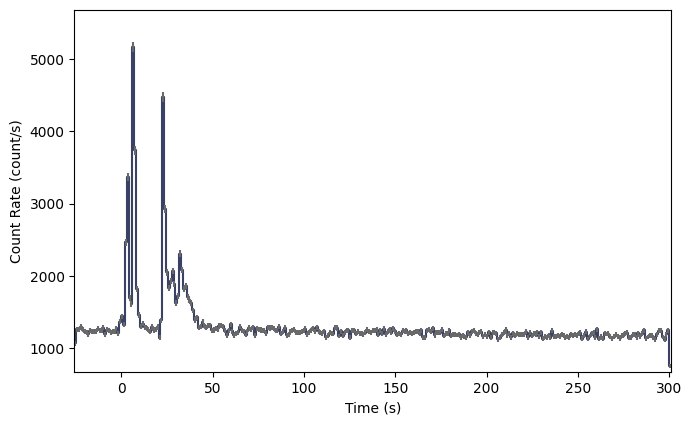

In [10]:
from gdt.core.plot.lightcurve import Lightcurve

# convert the data into a lightcurce and plot it
lcplot = Lightcurve(data=phaii.to_lightcurve())
plt.show()

One thing to note: if we want to temporally rebin the data, we could certainly rebin the PHAII object, but in order to leverage the full power and flexibility of TTE, it would be good to (re)bin the TTE data instead to create a new PHAII object.

To plot the spectrum, we don’t have to worry about binning the data, since the TTE is already necessarily pre-binned in energy. So, we can make a spectrum plot directly from the TTE object without any extra steps using the `Spectrum` class:

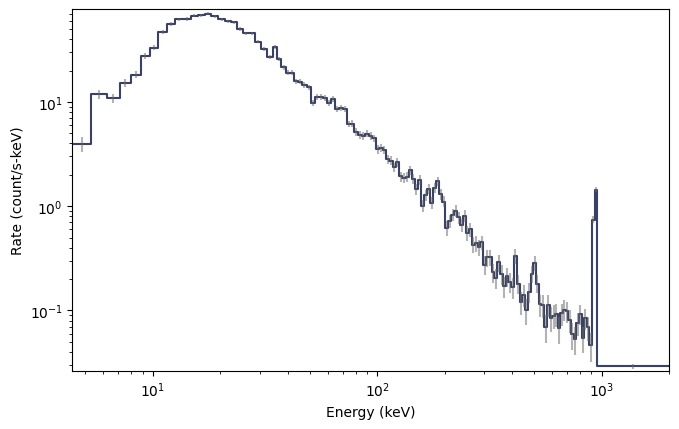

In [11]:
from gdt.core.plot.spectrum import Spectrum

# convert the data into a count spectrum and integrate over time from 0 - 10 s
spectrum = tte.to_spectrum(time_range=(0.0, 10.0))

# plot the count spectrum
specplot = Spectrum(data=spectrum)
plt.show()

Perhaps the spectral resolution is a little bit higher than we need (i.e. if studying a weak source). We can rebin the count spectrum, but remember that the energy is pre-binned, so we need to use one of the Binning Algorithms for Binned Data. Here, we will use `combine_by_factor()`, which simply combines bins together by an integer factor.

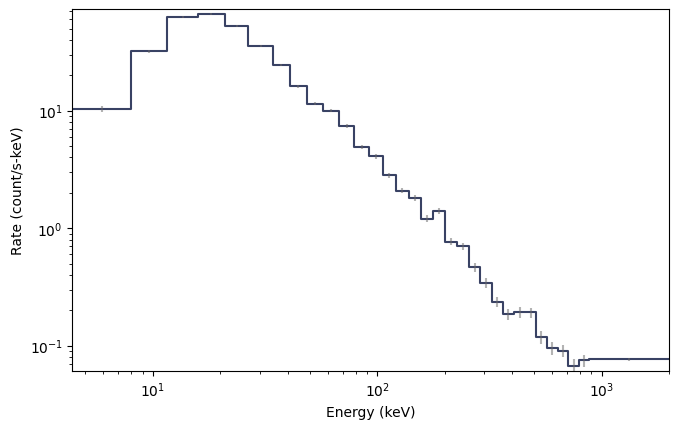

In [12]:
from gdt.core.binning.binned import combine_by_factor

# rebin the count spectrum by a factor of 4
rebinned_energy = tte.rebin_energy(combine_by_factor, 4)

# convert the rebinned data into a count spectrum and plot it
rebinned_spectrum = rebinned_energy.to_spectrum(time_range=(0.0, 10.0))
specplot = Spectrum(data=rebinned_spectrum)
plt.show()

As with the pre-binned types, we can convert one or more time selections to a single spectrum PHA object. You can do this from TTE without having to bin in time.

In [13]:
# create a pha object by integrating over 0-10 s and 30-50 s
pha = tte.to_pha(time_ranges=[(0.0, 10.0), (30.0, 50.0)])
print(pha)

<Pha: 
 trigger time: 255060563.149072;
 time range (0.0007220208644866943, 49.99965399503708);
 energy range (4.380217552185059, 2000.0)>


Sometimes, you might want to save snippets of TTE, or even merge your TTE snippets into one file and write it to file for later. You can do this as well, like so:

In [14]:
# slice a second section of tte data in time
time_sliced_tte2 = tte.slice_time([30.0, 50.0])

# merge our new time slice with the time slice we made earlier
tte_slices_merged = tte.merge([time_sliced_tte, time_sliced_tte2])
tte_slices_merged.time_range

(-9.999035984277725, 49.99965399503708)

Finally, we can write out a new fully-qualified GBM TTE FITS file after some reduction tasks. For example, we can write out our time-sliced data object:

In [16]:
# write new gbm tte fits file with time sliced tte data
time_sliced_tte.write('./', filename='my_first_custom_tte.fit', overwrite=True)

Congrats, you’ve just learned all about GBM TTE Data!